In [29]:
import geopandas as gpd
import pandas as pd
import matplotlib
import os
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Import des données

In [ ]:
path_data = r"C:\Users\hp\Documents\MITSIOMOTU\Prise phase2\2. Data\1. Analyse cas d'usage\MMRE"

# Import des limites administratives
cantons = gpd.read_file(os.path.join(path_data,'data','limites admin','14_11_22_Togo_Cantons2_4326.gpkg'))
communes = gpd.read_file(os.path.join(path_data,'data','limites admin','14_11_22_Communes_du_Togo_2.gpkg'))

cantons = cantons.to_crs(epsg='25231')
communes = communes.to_crs(epsg = '25231')

# Import du réseau BT
lignes_bt_gdf = gpd.read_file(os.path.join(path_data,'data','réseau BT','lignes_bt_total.gpkg'))
poteaux_gdf = gpd.read_file(os.path.join(path_data,'data','réseau BT','poteaux_bt_total.gpkg'))

# Import des branchements
branchements_gdf = gpd.read_file(os.path.join(path_data,'data','branchement','branchement_total.gpkg'))

# Import des ménages
menage_gdf = gpd.read_file(os.path.join(path_data,'data','ménage','menage_total.gpkg'))

# Import des concessions
concessions_total = gpd.read_file(os.path.join(path_data,'data','concession','concessions_total.gpkg'))

# Import de la population META : 
pop_point_gdf = gpd.read_file(os.path.join(path_data,'population','pop_rgph_point2.gpkg'))
## Lecture de la population dans les buffer autour du réseau BT
population_60 = gpd.read_file(os.path.join(path_data,'population','pop_rgph_point_60m_tinga.gpkg'))
population_70 = gpd.read_file(os.path.join(path_data,'population','pop_rgph_point_70m_tinga.gpkg'))
population_80 = gpd.read_file(os.path.join(path_data,'population','pop_rgph_point_80m_tinga.gpkg'))


DriverError: C:\Users\hp\Documents\MITSIOMOTU\Prise phase2\2. Data\1. Analyse cas d'usage\MMRE\data\ménage\concessions_total.gpkg: No such file or directory

In [31]:
# Import des concessions
concessions_total = gpd.read_file(os.path.join(path_data,'data','concession','concessions_total.gpkg'))

# Import de la population META : 
pop_point_gdf = gpd.read_file(os.path.join(path_data,'population','pop_rgph_point2.gpkg'))
## Lecture de la population dans les buffer autour du réseau BT
population_60 = gpd.read_file(os.path.join(path_data,'population','pop_rgph_point_60m_tinga.gpkg'))
population_70 = gpd.read_file(os.path.join(path_data,'population','pop_rgph_point_70m_tinga.gpkg'))
population_80 = gpd.read_file(os.path.join(path_data,'population','pop_rgph_point_80m_tinga.gpkg'))


KeyboardInterrupt: 

# Cacul des résultats 

Buffer et extraction des données dans les zones tampon

In [37]:

def generate_and_merge_buffers(poteaux_gdf, lignes_gdf, cantons, distance):
    """
    Crée un buffer autour des poteaux et des lignes, fusionne les buffers et découpe par canton.
    """
    # Fusionner les poteaux et les lignes
    all_features = pd.concat([poteaux_gdf, lignes_gdf])

    # Générer le buffer autour de toutes les entités
    all_features["buffer"] = all_features.geometry.buffer(distance)

    # Fusionner tous les buffers en une seule géométrie
    merged_buffer = all_features["buffer"].unary_union

    # Créer un GeoDataFrame avec cette géométrie fusionnée
    merged_buffers = gpd.GeoDataFrame(geometry=[merged_buffer], crs=poteaux_gdf.crs)

    # Découper ce buffer global sur les limites des cantons pour éviter les chevauchements
    clipped_buffers = gpd.overlay(merged_buffers, cantons, how="intersection")

    return clipped_buffers


# Définition des distances
distances = [70, 80]
path_out = os.path.join(path_data,'data','réseau BT','buffer')
# Variables pour stocker les buffers pour chaque distance
#buffer_60 = None
buffer_70 = None
buffer_80 = None

# Génération des buffers et sauvegarde des fichiers
for distance in distances:
    buffer_gdf = generate_and_merge_buffers(poteaux_gdf, lignes_bt_gdf,cantons, distance)

    # Assigner le buffer généré à la variable correspondante
    if distance == 60:
        buffer_60 = buffer_gdf
    elif distance == 70:
        buffer_70 = buffer_gdf
    elif distance == 80:
        buffer_80 = buffer_gdf
        
    # Définir le chemin du fichier
    output_file = os.path.join(path_out, f"zones_tampon_{distance}m.gpkg")

    # Sauvegarder le fichier GeoPackage
    buffer_gdf.to_file(output_file, driver="GPKG", layer=f"buffers_{distance}m")

    print(f"Fichier enregistré : {output_file}")

c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Fichier enregistré : C:\Users\hp\Documents\MITSIOMOTU\Prise phase2\2. Data\1. Analyse cas d'usage\MMRE\data\réseau BT\buffer\zones_tampon_70m.gpkg


c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Fichier enregistré : C:\Users\hp\Documents\MITSIOMOTU\Prise phase2\2. Data\1. Analyse cas d'usage\MMRE\data\réseau BT\buffer\zones_tampon_80m.gpkg


### Comptage du nombre de concessions, du nombre de ménages et de branchements dans le buffer

In [ ]:
# Initialiser un GeoDataFrame pour stocker les résultats consolidés
limites_admin_final = cantons.copy()
distances = [60, 70, 80]
path_out = os.path.join(path_data,'Résultats')

for distance in distances:
        # Assigner le buffer généré à la variable correspondante
    if distance == 60:
        buffer_gdf = buffer_60.copy() 
    elif distance == 70:
        buffer_gdf = buffer_70.copy() 
    elif distance == 80:
        buffer_gdf = buffer_80.copy() 

    # Suppression des colonnes 'index_left' et 'index_right' dans tous les GeoDataFrame avant les jointures
    buffer_gdf = buffer_gdf.drop(columns=['index_left', 'index_right'], errors='ignore')
    concessions_total = concessions_total.drop(columns=['index_left', 'index_right'], errors='ignore')
    menage_gdf = menage_gdf.drop(columns=['index_left', 'index_right'], errors='ignore')
    
    # **Statistiques dans les buffers**
    # Concessions dans le buffer
    concess_colonne = ['N_REGION', 'N_PREFECTURE', 'N_COMMUNE', 'N_CANTON', 'MILIEU', 'TAILLE','TAILLE_MENAGE','geometry']
    concessions_in_buffer = gpd.sjoin(concessions_total[concess_colonne], buffer_gdf, how="inner", predicate="within")
    nb_concessions = concessions_in_buffer.groupby("canton_nom").size().rename(f"nb_concessions_{distance}m")

    # Ménages dans le buffer
    menage_colonne = ['N_REGION','N_PREFECTURE','N_COMMUNE','N_CANTON','MILIEU','TAILLE_MENAGE','geometry']
    menages_in_buffer = gpd.sjoin(menage_gdf[menage_colonne], buffer_gdf, how="inner", predicate="within")
    nb_menages = menages_in_buffer.groupby("canton_nom").size().rename(f"nb_menages_{distance}m")

    # Branchements (filtrés par région)
    branchement_buff = branchements_gdf.groupby("canton_nom").size().rename(f"nb_branchements_{distance}m")

    # **Fusion des statistiques avec les limites administratives**
    limites_admin_temp = limites_admin_final.copy()
    limites_admin_temp = limites_admin_temp.merge(nb_concessions, on="canton_nom", how="left")
    limites_admin_temp = limites_admin_temp.merge(nb_menages, on="canton_nom", how="left")
    limites_admin_temp = limites_admin_temp.merge(branchement_buff, on="canton_nom", how="left")


    # **Joindre les statistiques avec les buffers**
    buffer_temp= buffer_gdf.copy()
    # Fusionner les statistiques dans les buffers
    buffer_temp = buffer_temp.merge(nb_concessions, on="canton_nom", how="left")
    buffer_temp = buffer_temp.merge(nb_menages, on="canton_nom", how="left")
    buffer_temp = buffer_temp.merge(branchement_buff, on="canton_nom", how="left")

    # **Enregistrement des fichiers** avec les buffers et statistiques jointes
    output_gpkg_buffer = os.path.join(path_out, f"zones_tampon_result_{distance}m.gpkg")
    buffer_temp.to_file(output_gpkg_buffer, driver="GPKG", layer=f"buffers_{distance}m")

    output_excel_buffer = os.path.join(path_out, f"zones_tampon_result_{distance}m.xlsx")
    buffer_temp.drop(columns="geometry").to_excel(output_excel_buffer, index=False)

    output_gpkg_canton = os.path.join(path_out, f"limites_admin_stats_{distance}m.gpkg")
    limites_admin_temp.to_file(output_gpkg_canton, driver="GPKG")

    output_excel_canton = os.path.join(path_out, f"limites_admin_stats_{distance}m.xlsx")
    limites_admin_temp.drop(columns="geometry").to_excel(output_excel_canton, index=False)

    print(f"Fichiers enregistrés pour {distance}m")



c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Fichiers enregistrés pour 60m :


c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Fichiers enregistrés pour 70m :


c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Fichiers enregistrés pour 80m :


## Analyse de la distance entre un ménage connecté et le plus proche poteau BT

In [ ]:
support_bt_prise = gpd.read_file(os.path.join(path_data,'data','réseau BT','PRISE','ener_poteaux_bt.gpkg'))
support_bt_prise = support_bt_prise.to_crs(25231)

# Filtrer les ménages en fonction de la valeur du champ 'H08_Impute'
filtered_menages = menage_gdf[menage_gdf ['prefecture_nom'].isin(['Agoè-Nyivé','Golfe' ] )]
filtered_menages = filtered_menages[filtered_menages["H08_Impute"].isin([    "Electricité (CEET) compteur dans la concession" ]   ) ]

poteau_jointure = support_bt_prise[['region','prefecture','commune','canton','id','geometry']]

# Utilisation de sjoin_nearest pour trouver le support BT le plus proche
# Cette opération va joindre chaque ménage avec le poteau le plus proche et calculer la distance
nearest_poteaux = gpd.sjoin_nearest(
    filtered_menages[['ID_HHFtth','ID_RGPH','geometry']], 
    poteau_jointure, 
    how="left", 
    distance_col="distance_to_nearest_support",  # Ajouter une colonne pour la distance
    max_distance=None  # On peut spécifier une distance maximale, sinon laisser None pour tout considérer
)

# Extraire les distances
distances = nearest_poteaux['distance_to_nearest_support']


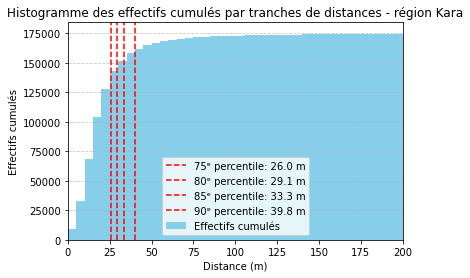

In [ ]:
import matplotlib.pyplot as plt


# Créer les tranches de distances (par pas de 5 mètres)
bins = np.arange(0, distances.max() + 5, 5)  # Tranches de 5 mètres
hist, bin_edges = np.histogram(distances, bins=bins)  # Histogramme simple

# Calculer les effectifs cumulés
cumulative_effectifs = np.cumsum(hist)

# Calculer les percentiles
percentiles = [75, 80,85, 90]
percentile_values = np.percentile(distances, percentiles)

# Créer le graphique
plt.bar(bin_edges[:-1], cumulative_effectifs, width=5, align='edge', color='skyblue', label="Effectifs cumulés")

# Ajouter les lignes verticales pour les percentiles
for p, value in zip(percentiles, percentile_values):
    plt.axvline(value, color='red', linestyle='--', label=f"{p}ᵉ percentile: {value:.1f} m")

# Personnaliser le graphique
plt.title("Histogramme des effectifs cumulés par tranches de distances - région Kara")
plt.xlabel("Distance (m)")
plt.ylabel("Effectifs cumulés")
plt.xlim(0,200)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


## Population concessions et ménages dans les zones -60 , 60m-2km et +2km

### Dans la zone - 60m

In [40]:
# Calcul de la population dans le buffer
pop_point_gdf = pop_point_gdf.rename(columns={"index": "pop_index"})

# Intersecter les points de population avec les buffers
pop_within_buffers = gpd.sjoin(pop_point_gdf, buffer_80, predicate="within", how="left", rsuffix="buff")

# Regrouper par canton et sommer la population
pop_by_canton = pop_within_buffers.groupby("canton_nom_buff")["tgo_general_2020"].sum().reset_index()

# Sauvegarde (ou copie dans le presse-papier pour tester)
pop_by_canton.to_clipboard()

print("✅ Population dans le buffer calculée et copiée dans le presse-papier.")

✅ Population dans le buffer calculée et copiée dans le presse-papier.


In [ ]:
# Lecture des résultats
population_60.groupby(by='canton_nom').sum().to_clipboard()
#population_70.groupby(by='canton_nom').sum() 
#population_80.groupby(by='canton_nom').sum() 

### Entre 60m et 2000m du réseau BT

In [20]:
def generate_buffer_zone(poteaux_gdf, lignes_gdf, distance_60, distance_2000):
    """Crée un buffer unique pour la zone 60m-2000m en fusionnant poteaux et lignes."""
    # Fusionner les poteaux et les lignes
    all_features = pd.concat([poteaux_gdf, lignes_gdf])

    # Générer les buffers de 60m et 2000m
    buffer_60m = all_features.copy()
    buffer_60m["geometry"] = buffer_60m.geometry.buffer(distance_60)

    buffer_2000m = all_features.copy()
    buffer_2000m["geometry"] = buffer_2000m.geometry.buffer(distance_2000)

    # Dissoudre pour éviter la superposition entre objets
    buffer_60m = buffer_60m.dissolve()
    buffer_2000m = buffer_2000m.dissolve()

    # Assurer une géométrie unique après dissolution
    buffer_60m = buffer_60m.geometry.unary_union
    buffer_2000m = buffer_2000m.geometry.unary_union

    # Calculer la zone tampon entre 60m et 2000m
    buffer_zone = buffer_2000m.difference(buffer_60m)

    # Convertir en GeoDataFrame propre
    buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_zone], crs=poteaux_gdf.crs)

    return buffer_gdf

def clip_buffer_by_canton(buffer_gdf, cantons_gdf):
    """Découpe le buffer global selon les limites cantonales et attribue les cantons."""
    clipped_buffers = gpd.overlay(buffer_gdf, cantons_gdf, how="intersection")
    return clipped_buffers

# Étape 1 : Générer le buffer global 60m-2000m
buffer_gdf = generate_buffer_zone(poteaux_gdf, lignes_bt_gdf, 60, 2000)

# Étape 2 : Découper ce buffer sur les cantons
buffer_diff_gdf = clip_buffer_by_canton(buffer_gdf, cantons)

print(buffer_diff_gdf.head())

buffer_diff_gdf.to_file(os.path.join(path_data,'data','réseau BT','buffer','buffer_diff_60_2000.gpkg'),geometry = 'buffer_diff',driver = 'GPKG')

  region_id region_nom prefecture_id prefecture_nom commune_id   commune_nom  \
0         A   Maritime           A01     Agoè-Nyivé     A01001  Agoè-Nyivé 1   
1         A   Maritime           A01     Agoè-Nyivé     A01002  Agoè-Nyivé 2   
2         A   Maritime           A01     Agoè-Nyivé     A01003  Agoè-Nyivé 3   
3         A   Maritime           A01     Agoè-Nyivé     A01004  Agoè-Nyivé 4   
4         A   Maritime           A01     Agoè-Nyivé     A01005  Agoè-Nyivé 5   

   canton_id  canton_nom canton_nom_alt  grand_lome    Shape_Leng  \
0  A01001001  Agoè-Nyivé     Agoé-Nyivé         1.0  29477.785269   
1  A01002002  Légbassito     Légbassito         1.0  21982.365357   
2  A01003003  Vakpossito     Vakpossito         1.0  10619.447559   
3  A01004004  Togblekope         Togblé         1.0  27501.274085   
4  A01005005    Sanguera       Zanguéra         1.0  25069.332951   

     Shape_Area                                           geometry  
0  4.236808e+07  MULTIPOLYGON (((30

In [24]:
# Calcul de la population dans le buffer
pop_point_gdf = pop_point_gdf.rename(columns={"index": "pop_index"})
buffer_diff_gdf = buffer_diff_gdf.rename(columns={"index": "buffer_index"})

# Intersecter les points de population avec les buffers
pop_within_buffers = gpd.sjoin(pop_point_gdf, buffer_diff_gdf, predicate="within", how="left", rsuffix="buff")

# Regrouper par canton et sommer la population
pop_by_canton = pop_within_buffers.groupby("canton_nom_buff")["tgo_general_2020"].sum().reset_index()

# Sauvegarde (ou copie dans le presse-papier pour tester)
pop_by_canton.to_clipboard()

print("✅ Population dans le buffer calculée et copiée dans le presse-papier.")

✅ Population dans le buffer calculée et copiée dans le presse-papier.


In [43]:
# Calcul du nombre de concession dans le buffer
# Intersecter les points de population avec les buffers
#conces_within_buffers = gpd.sjoin(concessions_total, buffer_diff_gdf, predicate="within", how="left", rsuffix="buff")
menage_within_buffers = gpd.sjoin(menage_gdf, buffer_diff_gdf, predicate="within", how="left", rsuffix="buff")

# Regrouper par canton et sommer la population
#conces_within_buffers_canton = conces_within_buffers.groupby("canton_nom_buff").size().reset_index()
menage_within_buffers_canton = menage_within_buffers.groupby("canton_nom_buff").size().reset_index()

# Sauvegarde (ou copie dans le presse-papier pour tester)
#conces_within_buffers_canton.to_clipboard()
menage_within_buffers_canton.to_clipboard()

print("✅ Nbr de menage dans le buffer calculée et copiée dans le presse-papier.")

✅ Nbr de menage dans le buffer calculée et copiée dans le presse-papier.


### A plus de 2km du réseau BT

In [27]:
def generate_outside_buffer(poteaux_gdf, lignes_gdf, cantons, distance):
    """
    Crée la zone en dehors du buffer de 2000m du réseau BT.
    """
    # Générer les buffers de 2000m autour des poteaux et lignes
    poteaux_gdf["buffer"] = poteaux_gdf.geometry.buffer(distance)
    lignes_gdf["buffer"] = lignes_gdf.geometry.buffer(distance)

    # Fusionner les buffers pour éviter les chevauchements
    all_buffers = gpd.GeoDataFrame(geometry=poteaux_gdf["buffer"].union(lignes_gdf["buffer"]), crs=poteaux_gdf.crs)

    # Dissoudre en une seule géométrie pour chaque canton
    all_buffers = all_buffers.dissolve()

    # Vérifier que la géométrie est bien définie
    all_buffers = all_buffers.set_geometry("geometry")

    # Soustraction des buffers aux limites des cantons
    cantons = cantons.copy()  # Pour éviter de modifier l'original
    cantons["geometry"] = cantons.geometry.difference(all_buffers.geometry.unary_union)

    return cantons


# Générer la zone au-delà de 2000m
outside_buffer_gdf = generate_outside_buffer(poteaux_gdf, lignes_bt_gdf, cantons.copy(), 2000)

# Vérifier que la géométrie est bien définie après la soustraction
outside_buffer_gdf = outside_buffer_gdf.set_geometry("geometry")
outside_buffer_gdf.to_file(os.path.join(path_data,'data','réseau BT','buffer','buffer_plus_2000.gpkg'),driver = 'GPKG')



c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
# Intersecter les points de population avec la zone
pop_outside_buffers = gpd.sjoin(pop_point_gdf, outside_buffer_gdf, predicate="within", how="left", rsuffix="out")

# Agréger la population par canton
pop_out_by_canton = pop_outside_buffers.groupby("canton_nom_out")["tgo_general_2020"].sum().reset_index()

# Sauvegarde (ou copie dans le presse-papier pour tester)
pop_out_by_canton.to_clipboard()
print("✅ Population au-delà de 2000m calculée et copiée dans le presse-papier.")



In [ ]:
# Calcul du nombre de concession dans le buffer
# Intersecter les points de population avec les buffers
conces_within_buffers = gpd.sjoin(concessions_total, outside_buffer_gdf, predicate="within", how="left", rsuffix="buff")
#menage_within_buffers = gpd.sjoin(menage_gdf, outside_buffer_gdf, predicate="within", how="left", rsuffix="buff")

# Regrouper par canton et sommer la population
conces_within_buffers_canton = conces_within_buffers.groupby("canton_nom_buff").size().reset_index()
#menage_within_buffers_canton = menage_within_buffers.groupby("canton_nom_buff").size().reset_index()

# Sauvegarde (ou copie dans le presse-papier pour tester)
conces_within_buffers_canton.to_clipboard()
#menage_within_buffers_canton.to_clipboard()

print("✅ Nbr de concess dans le buffer calculée et copiée dans le presse-papier.")

✅ Nbr de concess dans le buffer calculée et copiée dans le presse-papier.
